# Planning Notebook

In [8]:
import math
import unittest
import numpy as np
from itertools import product

# import gtsam
import gtsam
from gtsam import *
from gtsam.utils.test_case import GtsamTestCase

# import gtbook
import gtbook
from gtbook.display import *
from gtbook.discrete import *

# import local package
import gtsam_example
from gtsam_example import SingleValueConstraint, MultiValueConstraint

# import parser
import SASParser
from SASParser import SAS, Operator

variables = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, variables)

import graphviz
class show(graphviz.Source):
    """ Display an object with a dot method as a graph."""

    def __init__(self, obj):
        """Construct from object with 'dot' method."""
        # This small class takes an object, calls its dot function, and uses the
        # resulting string to initialize a graphviz.Source instance. This in turn
        # has a _repr_mimebundle_ method, which then renders it in the notebook.
        super().__init__(obj.dot())

In [9]:
class SASToGTSAM():
    def __init__(self, sas):
        self.sas = sas
        self.init = sas.initial_state
        self.goal = sas.goal
        self.vars = self.sas.variables
        self.ops = self.sas.operators
        self.mutex_groups = self.sas.mutex_group
        self.ops_names = []
        for op in self.ops:
            self.ops_names.append(op.name)

    def generate_string(self, cardinality, val):
        string_list = []
        for i in range(cardinality):
            string_list.append("0")
        string_list[val] = "1"
        string = ' '.join(string_list)
        return string
    
    def generate_state(self, timestep):
        state = []
        for var, val in self.vars.items():
            state_var = variables.discrete(str(var)+"_"+str(timestep), val)
            state.append(state_var)
        return state
    
    def generate_operator(self, timestep):
        operators = []
        for op in self.ops:
            op_var = variables.binary(op.name+"_"+str(timestep))
            operators.append(op_var)
        return operators
    
    def generate_initial_factor(self):
        initial_state = self.generate_state(0)
        keys = gtsam.DiscreteKeys()
        for key in self.init:
            keys.push_back(key)
        
        multi_f = MultiValueConstraint(keys, list(self.init.values()))
        # init_f = gtsam.DecisionTreeFactor()
        # for i, var_val in enumerate(self.init.items()):
        #     single_f = SingleValueConstraint(initial_state[i], var_val[1])
        #     f = single_f.toDecisionTreeFactor()
        #     init_f *= f
        # return init_f
        return multi_f

    def generate_goal_factor(self, goal_state):
        state = list(self.vars.keys())
        goal_f = gtsam.DecisionTreeFactor()
        for goal_var, goal_val in self.goal.items():
            state_var = goal_state[state.index(goal_var)]
            single_f = SingleValueConstraint(state_var, goal_val)
            f = single_f.toDecisionTreeFactor()
            goal_f *= f
        return goal_f

    def generate_op_factor(self, state_t, state_tp, op_t, operator):
        state = list(self.vars.keys())
        preconditions = operator.precondition
        effects = operator.effect
        prevail = operator.prevail
        f = gtsam.DecisionTreeFactor(op_t, self.generate_string(2, 1))
        for pre_var, pre_val in preconditions.items():
            state_var = state_t[state.index(pre_var)]
            cardinality = state_var[1]
            state_f = gtsam.DecisionTreeFactor(state_var, self.generate_string(cardinality, pre_val))
            f *= state_f
        for eff_var, eff_val in effects.items():
            state_var = state_tp[state.index(eff_var)]
            cardinality = state_var[1]
            state_f = gtsam.DecisionTreeFactor(state_var, self.generate_string(cardinality, eff_val))
            f *= state_f
        if prevail:
            for prev_var, prev_val in prevail.items():
                state_var_t = state_t[state.index(prev_var)]
                state_var_tp = state_tp[state.index(prev_var)]
                cardinality = state_var[1]
                state_t_f = gtsam.DecisionTreeFactor(state_var_t, self.generate_string(cardinality, prev_val))
                state_tp_f = gtsam.DecisionTreeFactor(state_var_tp, self.generate_string(cardinality, prev_val))
                f *= state_t_f
                f *= state_tp_f
        return f

    def valid(self, values, mutex):
        assert len(values) == len(mutex)
        count = 0
        for v, m in zip(values, mutex):
            if v == m:
                count += 1
            if count > 1:
                return "0"
        return "1"

    def generate_mutex_factor(self, state_t):
        state = list(self.vars.keys())
        mutex_variables = []
        mutex_values = []
        
        for mutex_group in self.mutex_groups:
            var_group = []
            val_group = []
            for var, val in mutex_group:
                state_var = state_t[state.index(var)]
                var_group.append(state_var)
                val_group.append(val)
            mutex_variables.append(var_group)
            mutex_values.append(val_group)
        
        f = gtsam.DecisionTreeFactor()
        for mutex_var, mutex_val in zip(mutex_variables, mutex_values):
            input = []
            for var in mutex_var:
                input.append(list(range(var[1])))
            prods = list(product(*input))
            mutex_string_list = []
            for prod in prods:
                is_valid = self.valid(prod, mutex_val)
                mutex_string_list.append(is_valid)
            mutex_string = ' '.join(mutex_string_list)
            f = f*gtsam.DecisionTreeFactor(mutex_var, mutex_string)
        return f

In [91]:
a = (3,2)
b = (4,2)
single = SingleValueConstraint(a, 1)

In [92]:
values = DiscreteValues()
values[a[0]] = 1
values[b[0]] = 1


In [93]:
values

DiscreteValues{3: 1, 4: 1}

In [94]:
single(values)

1.0

In [ ]:
var1 = []
var1: 0
var2: 0

In [10]:
sas = SAS()
sas_dir = "sas/block_example.sas"
sas.read_file(sas_dir)
converter = SASToGTSAM(sas)

In [29]:
names = converter.ops_names # 1, 43, 66, 111, 131, 179

In [11]:
def plan(k):
    if k < 1:
        return "There should be at least one state"
    states = []
    operators = []
    mutex_factors = []
    op_factors = []
    for i in range(k-1):
        state_t = converter.generate_state(i)
        operators_t = converter.generate_operator(i)
        states.append(state_t)
        operators.append(operators_t)
    last_state = converter.generate_state(k-1)
    states.append(last_state)
    for j in range(len(states)-1):
        mutex_factor = converter.generate_mutex_factor(states[j])
        mutex_factors.append(mutex_factor)
        # op_group = []
        for op_t, op in zip(operators[j], converter.ops):
            op_factor = converter.generate_op_factor(states[j], states[j+1], op_t, op)
            # op_group.append(op_factor)
            op_factors.append(op_factor)
        # op_factors.append(op_group)
    last_mutex_factor = converter.generate_mutex_factor(states[-1])
    mutex_factors.append(last_mutex_factor)
    initial_factor = converter.generate_initial_factor()
    goal_factor = converter.generate_goal_factor(states[-1])
    return states, initial_factor,  goal_factor, mutex_factors, op_factors

In [12]:
states, initial_factor,  goal_factor, mutex_factors, op_factors = plan(7)

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. gtsam.gtsam.DiscreteKeys()

Invoked with: [(255, 5), (256, 2), (257, 2), (258, 2), (259, 2), (260, 2), (261, 5), (262, 5), (263, 5)]

In [32]:
graph = gtsam.DiscreteFactorGraph()

In [33]:
graph.push_back(op_factors[1])
graph.push_back(op_factors[43])
graph.push_back(op_factors[66])
graph.push_back(op_factors[111])
graph.push_back(op_factors[131])
graph.push_back(op_factors[179])
graph.push_back(goal_factor)
graph.push_back(initial_factor)

In [34]:
for mutex_factor in mutex_factors:
    graph.push_back(mutex_factor)

In [35]:
val = graph.optimize()

In [36]:
graph(val)

1.0

In [37]:
val

DiscreteValues{0: 4, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 4, 7: 4, 8: 4, 10: 1, 41: 4, 42: 0, 43: 1, 44: 0, 45: 0, 46: 1, 47: 0, 48: 4, 49: 4, 61: 1, 82: 3, 83: 1, 84: 0, 85: 0, 86: 1, 87: 0, 88: 1, 89: 4, 90: 4, 93: 1, 123: 4, 124: 0, 125: 0, 126: 1, 127: 0, 128: 1, 129: 4, 130: 0, 131: 4, 147: 1, 164: 4, 165: 0, 166: 1, 167: 0, 168: 0, 169: 0, 170: 4, 171: 2, 172: 4, 176: 1, 205: 4, 206: 0, 207: 0, 208: 0, 209: 1, 210: 1, 211: 4, 212: 4, 213: 0, 233: 1, 246: 4, 247: 1, 248: 1, 249: 1, 250: 0, 251: 0, 252: 1, 253: 2, 254: 3, 255: 4, 256: 0, 257: 0, 258: 0, 259: 0, 260: 0, 261: 4, 262: 4, 263: 4}

In [59]:
for mutex_factor in mutex_factors:
    graph.push_back(mutex_factor)

In [69]:
for op_factor in op_factors:
    graph.push_back(op_factor)

In [91]:
graph.push_back(goal_factor)
graph.push_back(initial_factor)

In [59]:
a = (0, 2)
b = (1, 2)
c = (2, 2)
d = (3, 3)

In [60]:
f = DecisionTreeFactor([a, b, c], "1 1 1 1 1 1 1 1")

In [62]:
f

0,1,2,value
0,0,0,1
0,0,1,1
0,1,0,1
0,1,1,1
1,0,0,1
1,0,1,1
1,1,0,1
1,1,1,1


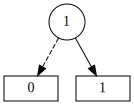

In [55]:
show(b_f)

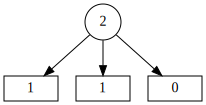

In [56]:
show(c_f)

In [57]:
f = d_f * a_f * b_f * c_f

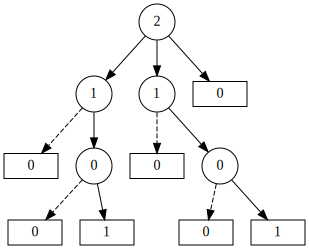

In [58]:
show(f)

In [68]:
op_var = [a,b,c]
input = []
for var in op_var:
    input.append(list(range(var[1])))
prods = list(product(*input))

In [69]:
prods

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [ ]:
class OperatorFactor(gtsam.DecisionTreeFactor):
    def __init__(self, op_vars, factors):
        input = []
        for op_var in op_vars:
            input.append(list(range(op_var[1])))
        prods = list(product(*input))


    